In [1]:
import utils
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import cv2
import albumentations as A
import seaborn as sns
from PIL import Image
from tqdm import tqdm

## Normal distribution loss

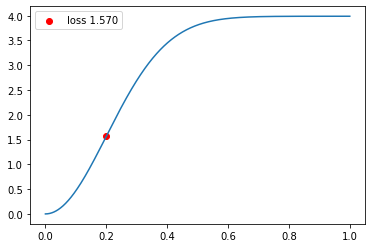

In [2]:
def normal_dist(x , mean , sd):
    prob_density = 1/(sd*np.sqrt(2*np.pi))* np.exp(-0.5*((x-mean)/(2*sd))**2)
    return prob_density

x = np.arange(0, 1, 0.001)
p = 0.2
sd = 0.1
max = 10/(np.sqrt(2*np.pi))
f = max-normal_dist(x,0,sd)
loss = max-normal_dist(p,0,sd)

plt.plot(x,f)
plt.scatter(p,loss, c='r',label="loss {:.3f}".format(loss))
plt.legend()
plt.show()

## List (and rename depth images)

In [3]:
train_path,train_name = utils.list_files("/zhome/3b/d/154066/repos/GALIROOT/data/l515_lab_1410/img/temp", ".png")
_,test_name = utils.list_files("/zhome/3b/d/154066/repos/GALIROOT/data/l515_lab_1410_test/img", ".png")

d_path, d_name = utils.list_files("/home/bbejczy/repos/GALIROOT/data/l515_imgs/", ".png")

test_out = "/home/bbejczy/repos/GALIROOT/data/l515_lab_1410_test/depth/"
train_out = "/home/bbejczy/repos/GALIROOT/data/l515_lab_1410/depth/"

# def _replace_text(list, oldtext, newtext):
#     newlist = []
#     for name in list:
#         name = name.replace(oldtext,newtext)
#         newlist.append(name)
#     return newlist

# train_d_list = _replace_text(train_name, "rgb", "depth")
# test_d_list = _replace_text(test_name, "rgb", "depth")

# tc, tec = 0,0

# for idx, name in enumerate(d_name):
#     # print(name)
#     if "depth" in name:
#         if name in test_d_list:
#             try: 
#                 shutil.copyfile(d_path[idx],test_out+f"{name}")
#                 tec += 1
#             except shutil.Error:
#                 print(f"{name} already exists")
#                 pass
#         if name in train_d_list:
#             try: 
#                 shutil.copyfile(d_path[idx],train_out+f"{name}")
#                 tc += 1
#             except shutil.Error:
#                 print(f"{name} already exists")
#                 pass

# print(f"train {tc} test {tec}")

In [4]:
train_path_d,train_name_d = utils.list_files("/zhome/3b/d/154066/repos/GALIROOT/data/l515_lab_1410/depth/temp", ".png")
_,test_name_d = utils.list_files("/zhome/3b/d/154066/repos/GALIROOT/data/l515_lab_1410_test/depth", ".png")

## Mapping from 0-1

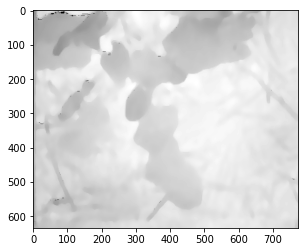

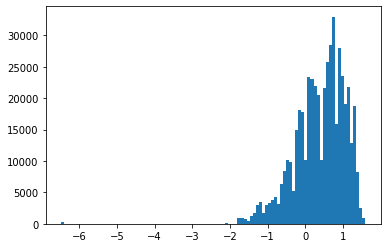

In [19]:
image_pil = np.asarray(Image.open(train_path_d[70]))

transform = A.Compose([A.Crop(x_min=345,y_min=365,x_max=1120,y_max=1000), A.Normalize(mean = [0.7188], std = [0.1109])]) #, A.Normalize(mean = [0.7188], std = [0.1109])]

img = ((image_pil-300)*255)/((500-300)) # subtracting lower bound, dividing by "new" upper bound"
img = img.clip(min=0, max=255) # clipping extra values, as we do not use absolute upper and lower bound
transformed = transform(image =img)
plt.imshow(transformed['image'], cmap='gray')
plt.show()
plt.figure(2)
plt.hist(transformed['image'].ravel(),bins=100);

plt.show();

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


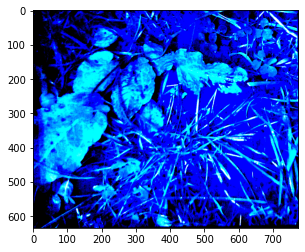

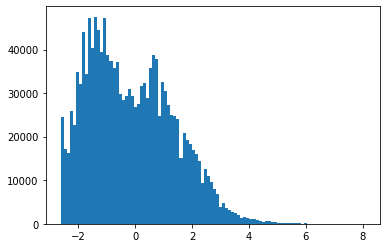

In [11]:
image = cv2.imread(train_path[100])

transform = A.Compose([A.Crop(x_min=345,y_min=365,x_max=1120,y_max=1000), A.Normalize(mean=[0.3399, 0.3449, 0.1555], std=[0.1296, 0.1372, 0.1044])]) #, A.Normalize(mean = [0.7188], std = [0.1109])]

# img = ((image_pil-300)*255)/((500-300)) # subtracting lower bound, dividing by "new" upper bound"
# img = img.clip(min=0, max=255) # clipping extra values, as we do not use absolute upper and lower bound
transformed = transform(image =image)
plt.imshow(transformed['image'], cmap='gray')
plt.show()
plt.figure(2)
plt.hist(transformed['image'].ravel(),bins=100);

plt.show();

Count how many entries would fall outside of the max with the different ranges

In [7]:
transform = A.Compose([A.Crop(x_min=345,y_min=365,x_max=1120,y_max=1000), A.Normalize(mean = [180.62], std = [47.2969])]) #
count=0
for path in tqdm(train_path_d):
    image_pil = np.asarray(Image.open(path))
    img = (image_pil-300)*255/((500-300))
    img = img.clip(min=0)
    transformed = transform(image =img)
    # print(transformed['image'].max())
    if transformed['image'].max()>255:
        count+=1
print(count)

100%|██████████| 111/111 [00:06<00:00, 16.64it/s]

0
